# 1. Load data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Select_Healthcare-Dataset-Stroke-Data.csv'
df = pd.read_csv(path)

# 2. Find out basic information

In [3]:
df.head()

,age,gender,work_type,Residence_type,smoking_status,avg_glucose_level_cut,bmi_rep,stroke
0,67.0,0,0,1,1,5,36.600000,1
1,80.0,0,0,0,0,3,32.500000,1
2,81.0,0,0,1,1,4,29.000000,1
3,74.0,0,0,0,0,1,27.400000,1
4,78.0,0,0,1,255,5,27.247222,1


In [4]:
df.shape

(5109, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5109 entries, 0 to 5108
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    5109 non-null   float64
 1   gender                 5109 non-null   int64  
 2   work_type              5109 non-null   int64  
 3   Residence_type         5109 non-null   int64  
 4   smoking_status         5109 non-null   int64  
 5   avg_glucose_level_cut  5109 non-null   int64  
 6   bmi_rep                5109 non-null   float64
 7   stroke                 5109 non-null   int64  
dtypes: float64(2), int64(6)
memory usage: 319.4 KB


# 3.  Model preparation

## 3.1 Label coding, X, y establishment

In [6]:
X  = df.drop(['stroke'],axis=1)
y = df['stroke']

## 3.2 Establish training set, test set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.3, random_state=42)

## 3.3 Data balancing

In [8]:
from imblearn.over_sampling import SMOTE
smo = SMOTE(random_state=42)

In [9]:
over_samples = SMOTE()
X_train_resh, y_train_resh = over_samples.fit_resample(X_train, y_train)

Our data is now equal!

# 4. Models

## 4.1 Scaling the Data

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score

In [11]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [12]:
rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])

## 4.2 cross_val_score

In [13]:
rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [14]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.9455041593898017
Logistic Regression mean : 0.8416339843893814


Random Forest performed the best. 

## 4.3 Random Forest

We will try using a grid search to find the optimal parameters for our Random Forest.

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

### cross validation

In [16]:
from sklearn.model_selection import GridSearchCV

n_estimators =[64,100,128,200]
max_features = [2,3,5,7]
bootstrap = [True,False]

param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap}

In [17]:
rfc = RandomForestClassifier()

In [18]:
grid = GridSearchCV(rfc,param_grid)

grid.fit(X_train,y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 5, 7],
                         'n_estimators': [64, 100, 128, 200]})

### the optimal parameters

In [19]:
grid.best_params_

{'bootstrap': True, 'max_features': 5, 'n_estimators': 64}

### model fitting

In [20]:
rfc = RandomForestClassifier(max_features=2,n_estimators=100,bootstrap=True)

rfc.fit(X_train_resh,y_train_resh)

RandomForestClassifier(max_features=2)

### model predict

In [21]:
rfc_tuned_pred = rfc.predict(X_test)
rfc_tuned_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### model evaluation

In [22]:
class_report_1=classification_report(y_test,rfc_tuned_pred)
print(class_report_1)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3399
           1       0.14      0.26      0.18       178

    accuracy                           0.88      3577
   macro avg       0.55      0.59      0.56      3577
weighted avg       0.92      0.88      0.90      3577



In [23]:
accuracy_score_1=accuracy_score(y_test,rfc_tuned_pred)
accuracy_score_1

0.8817444786133631

In [24]:
f1_score_1=f1_score(y_test,rfc_tuned_pred)
f1_score_1

0.17864077669902914

### confusion_matrix

In [25]:
def generate_results(model, predictions, name):
    cl_rep = classification_report(y_test, predictions)
    print("\nThe classification report for " + name + " is:", cl_rep, sep = "\n")
    cm_model = confusion_matrix(y_test, predictions)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm_model, annot = True, cmap = 'Blues', annot_kws = {'size': 15}, square = True)
    plt.title('Confusion Matrix for ' + name, size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    plt.show() 


The classification report for Random Forest is:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3399
           1       0.14      0.26      0.18       178

    accuracy                           0.88      3577
   macro avg       0.55      0.59      0.56      3577
weighted avg       0.92      0.88      0.90      3577



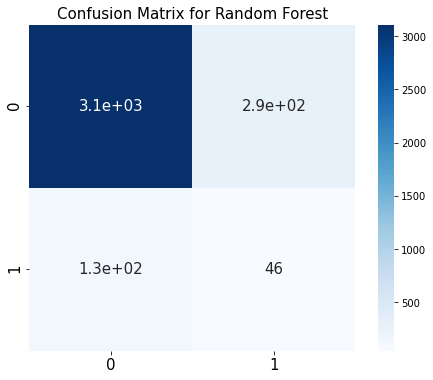

In [26]:
generate_results(rfc, rfc_tuned_pred, 'Random Forest')

### ROC Curve

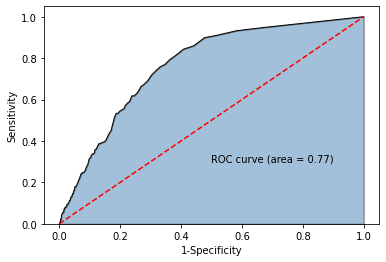

In [27]:
y_score = rfc.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)

plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

### KS Curve

In [28]:
def plot_ks(y_test, y_score, positive_flag):
    y_test.index = np.arange(len(y_test))
  
    target_data = pd.DataFrame({'y_test':y_test, 'y_score':y_score})
    
    target_data.sort_values(by = 'y_score', ascending = False, inplace = True)
    
    cuts = np.arange(0.1,1,0.1)
    
    index = len(target_data.y_score)*cuts
    scores = np.array(target_data.y_score)[index.astype('int')]
  
    Sensitivity = []
    Specificity = []
    for score in scores:
      
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) & (target_data.y_score>score),:].shape[0]
        positive = sum(target_data.y_test == positive_flag)
        
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)

    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity), 
                              'ks':np.array(Sensitivity)-(1-np.array(Specificity))})
   
    max_ks_index = np.argmax(plot_data.ks)
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label = '1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label = 'Sensitivity')
  
    plt.vlines(plot_data.cuts[max_ks_index], ymin = plot_data.y1[max_ks_index], 
               ymax = plot_data.y2[max_ks_index], linestyles = '--')

    plt.text(x = plot_data.cuts[max_ks_index]+0.01,
             y = plot_data.y1[max_ks_index]+plot_data.ks[max_ks_index]/2,
             s = 'KS= %.2f' %plot_data.ks[max_ks_index])
  
    plt.legend()

    plt.show()

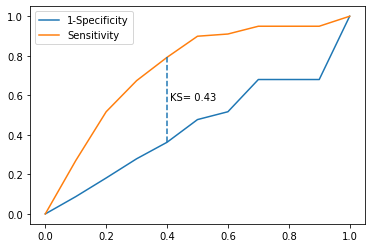

In [29]:
plot_ks(y_test, y_score, positive_flag=1)

### feature importances

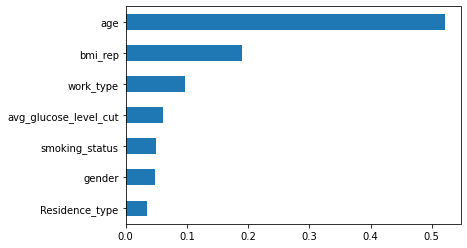

In [30]:
importance = rfc.feature_importances_

Impt_Series = pd.Series(importance, index = X_train.columns)

Impt_Series.sort_values(ascending = True).plot(kind='barh')
plt.show()

## 4.4 Logistic Regression

In [31]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### cross validation

In [32]:
penalty = ['l1','l2']

C = [0.001, 0.01, 0.1, 1, 10, 100] 

log_param_grid = {'penalty': penalty,'C': C}

In [33]:
logreg = LogisticRegression(max_iter=1000)

In [34]:
grid = GridSearchCV(logreg,log_param_grid)

grid.fit(X_train_resh,y_train_resh)

GridSearchCV(estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']})

### the optimal parameters

In [35]:
grid.best_params_

{'C': 1, 'penalty': 'l2'}

### model fitting

In [36]:
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(C=0.1,penalty='l2',random_state=42))])

logreg_pipeline.fit(X_train_resh,y_train_resh)

Pipeline(steps=[('scale', StandardScaler()),
                ('LR', LogisticRegression(C=0.1, random_state=42))])

### model predict

In [37]:
logreg_tuned_pred = logreg_pipeline.predict(X_test)

### model evaluation

In [38]:
class_report_2=classification_report(y_test,logreg_tuned_pred)
print(class_report_2)

              precision    recall  f1-score   support

           0       0.98      0.76      0.86      3399
           1       0.13      0.71      0.23       178

    accuracy                           0.76      3577
   macro avg       0.56      0.73      0.54      3577
weighted avg       0.94      0.76      0.82      3577



In [39]:
accuracy_score_2=accuracy_score(y_test,logreg_tuned_pred)
accuracy_score_2

0.7573385518590998

In [40]:
f1_score_2=f1_score(y_test,logreg_tuned_pred)
f1_score_2

0.225

### confusion_matrix


The classification report for Logistic Regression is:
              precision    recall  f1-score   support

           0       0.98      0.76      0.86      3399
           1       0.13      0.71      0.23       178

    accuracy                           0.76      3577
   macro avg       0.56      0.73      0.54      3577
weighted avg       0.94      0.76      0.82      3577



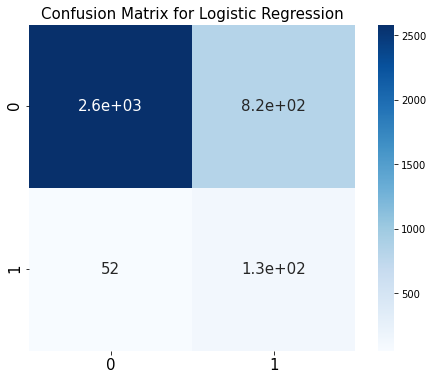

In [41]:
generate_results(logreg_pipeline,logreg_tuned_pred, 'Logistic Regression')

### ROC Curve

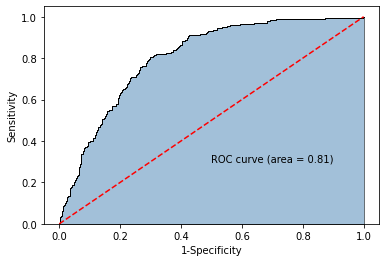

In [42]:
y_score = logreg_pipeline.predict_proba(X_test)[:,1]
fpr,tpr,threshold = metrics.roc_curve(y_test, y_score)
roc_auc = metrics.auc(fpr,tpr)

plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
plt.plot(fpr, tpr, color='black', lw = 1)
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
plt.text(0.5,0.3,'ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.show()

### KS Curve

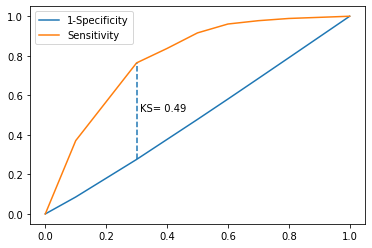

In [43]:
plot_ks(y_test, y_score, positive_flag=1)